In [1]:
# ┌────────────────────────────────────────────────────────────────────┐
# │                       Notebook Parameters                        │
# └────────────────────────────────────────────────────────────────────┘
FILE_PATH   = "/home/jupyter/Style_annotation_prod/Data/LLM Style Annotations.xlsx"
SHEET_NAME  = "Expert Evaluation"
OUT_DIR     = "/home/jupyter/Style_annotation_prod/Annotation_results"
# └────────────────────────────────────────────────────────────────────┘


In [3]:
import pandas as pd

df = pd.read_excel(FILE_PATH,SHEET_NAME,engine="openpyxl")
df.columns

Index(['product_1', 'Title 1', 'product_1_img', 'Image 1', 'product_2',
       'Title 2', 'product_2_img', 'Image 2', 'Simple Rule', 'ChatGPT',
       'Style? if Applicable',
       'ChatGPT Explanation on if they are stylistically compatible ',
       '[Expert] Agree/Disagree', '[Expert] Justification',
       '[Expert] stylistically relevant AND complementary? ',
       '[Expert] Rating 1-10 for stylistic relevancy (10 being the most relevant, optional) ',
       '[Expert] Name this style (optional) ', 'Yes and Agree', 'No and Agree',
       'Yes and Disagree', 'No and Disagree'],
      dtype='object')

In [11]:
#----------------------------------------
# Define the function to annotate styles and output results as a pd file
#----------------------------------------

import os, re, json, pandas as pd

def process_sheet(file_path: str, sheet_name: str) -> pd.DataFrame:
    df = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
    results = []
    for idx, row in df.iterrows():
        if (idx%10)==0:
            print(f"We already have {idx} results!")
        sku1, sku2 = row["product_1"], row["product_2"]
        print(f"Row {idx}: SKU1={sku1!r}, SKU2={sku2!r}")
        should_match = row['[Expert] stylistically relevant AND complementary? ']   # The ground truth label of compatibility
        data1 = product_cache.get_product_data([sku1], brand_catalog_id=1)
        print(f"  → returned {len(data1)} items for SKU1")
        try:
            p1 = product_cache.get_product_data([sku1], brand_catalog_id=1)[0]
            p2 = product_cache.get_product_data([sku2], brand_catalog_id=1)[0]
        except Exception as e:
            print(f"Fail to load product data for {sku1} or {sku2}:{e}")
            continue

        try:
            r, img1, img2 = annotate(p1, p2)   # The annotated label of Gemeni
            results.append(create_result(should_match, r, img1, img2, p1, p2))
        except Exception as e:
            print(f"Error on iteration {idx}: {e}")
            
    return pd.DataFrame(results)


In [5]:
#----------------------------------------
# Define LLM agent (Gemeni agent)
#----------------------------------------

import logging
from typing import List

import pandas as pd
import requests
from gql import Client, gql
from gql.transport.requests import RequestsHTTPTransport
from pydantic import BaseModel
from google.cloud import bigquery

client = bigquery.Client(project="wf-gcp-us-ae-recsvc-prod")

logging.getLogger("gql.transport.requests").setLevel(logging.WARNING)


class Ocid(BaseModel):
    ocid: int
    name: str
    url: str

class ProductTextInfo(BaseModel):
    prsku: str
    ireid: int
    base_image_url: str
    name: str
    clid: int
    clname: str
    romance_copy: str
    ocids: List[Ocid]
    number_of_ratings: int
    review_rating: float
    is_sale: bool


def image_url(lead_image_id: int, sku: str) -> str:
    return "https://secure.img1-fg.wfcdn.com/lf/unprocessed/hash/0/"+ str(lead_image_id) + "/1/c.jpg"



class ProductCacheClient:
    def __init__(self):
        BASE_URL = "http://kube-catalog-service-api.service.intraiad1.consul.csnzoo.com"
        AUTH_ENDPOINT = "/api/v1/Authentication/getWfAuthToken"
        GRAPHQL_ENDPOINT = "/api/v1/GraphQL"
        self.base_url = BASE_URL
        self.auth_endpoint = AUTH_ENDPOINT
        self.graphql_endpoint = GRAPHQL_ENDPOINT
        self.token = None
        self.client = None

    def _refresh_token(self):
        """Fetch a new access token from the authentication endpoint."""
        auth_url = f"{self.base_url}{self.auth_endpoint}"
        response = requests.post(auth_url)
        if response.status_code != 200:
            raise ValueError(f"Failed to obtain token: {response.content}")
        self.token = response.json().get("access_token")

        # Update the client with the new token
        transport = RequestsHTTPTransport(
            url=f"{self.base_url}{self.graphql_endpoint}",
            headers={"Authorization": f"Bearer {self.token}"},
        )
        self.client = Client(transport=transport, fetch_schema_from_transport=True)

    def _ensure_client(self):
        """Ensure the GraphQL client is initialized."""
        if not self.client:
            self._refresh_token()

    def get_product_data(
        self, skus: List[str], brand_catalog_id: int
    ) -> List[ProductTextInfo]:
        """Query the API for product name, clname, and romanceCopy."""
        self._ensure_client()

        query = gql(
            """query ProductQuery($brandCatalog: String!, $skus: [String!]!, $requestType: String) {
            products(brandCatalog: $brandCatalog, skus: $skus, requestType: $requestType) {
                name
                displaySku
                isFindable
                productClasses {
                    id
                    name
                }
                romanceCopy {
                    value
                }
                imageResourceId
                productOptions {
                    id
                    name
                    imageResourceId
                }
                numberOfRatings
                reviewRating
                promotion {
                    flag
                }
            }
        }"""
        )

        variables = {
            "brandCatalog": str(brand_catalog_id),
            "skus": skus,
            "requestType": "fullcatalog",
        }

        try:
            response_data = self.client.execute(query, variable_values=variables)
            products = response_data.get("products", [])
            results = []
            for sku, product in zip(skus, products):
                if (product is not None) and (product["isFindable"]):
                    options = [Ocid(ocid=x["id"], name=x["name"], url=image_url(x["imageResourceId"], sku), ireid=x["imageResourceId"]) for x in product['productOptions']]
                    product_info = ProductTextInfo(
                            prsku=sku,
                            ireid=product.get("imageResourceId"),
                            base_image_url = image_url(product.get("imageResourceId"), sku),
                            name=product.get("name"),
                            clname=product.get("productClasses")[0]["name"],
                            clid=product.get("productClasses")[0]["id"],
                            romance_copy="" if not product.get("romanceCopy") else str(product.get("romanceCopy")["value"]),
                            ocids=options,
                            number_of_ratings=product["numberOfRatings"],
                            review_rating=product["reviewRating"],
                            is_sale=bool(product["promotion"]["flag"]),
                        )
                    results.append(product_info)
            return results

        except Exception as e:
            if "401" in str(e):  # Token expired
                self._refresh_token()
                response_data = self.client.execute(query, variable_values=variables)
                return response_data.get("products", [])
            raise


def get_location(skus: List[str], level=1):
    stmt = f"""
    SELECT distinct SKU as prsku, FeatureValue as location
    FROM `wf-gcp-us-ae-merch-engg-prod.class_agnostic_attributes.product_feature_value`
    WHERE Feature='location' and BrandCatalogID=1 and SKU in {tuple(skus)}
        AND GranularityLevel={level}
    """
    df = client.query(stmt).to_dataframe()
    return df

# Example usage:
if __name__ == "__main__":
    BASE_URL = "http://kube-catalog-service-api.service.intraiad1.consul.csnzoo.com"
    AUTH_ENDPOINT = "/api/v1/Authentication/getWfAuthToken"
    GRAPHQL_ENDPOINT = "/api/v1/GraphQL"

    client = ProductCacheClient()
    skus = ["BFY1341", "SOY10484", "BX10056"]
    try:
        products = client.get_product_data(skus, 1)
        for p in products:
            print(p)

    except ValueError as e:
        raise e


def render_product_carousel_html(
        products: List[ProductTextInfo],
        visual =  List[ProductTextInfo],
        room_style=List[ProductTextInfo],
        output_path: str = "product_carousel.html") -> None:
    assert len(room_style)>1
    template_str = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8" />
        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
        <title>Product Carousel</title>
        <script src="https://cdn.jsdelivr.net/npm/alpinejs@3.x.x/dist/cdn.min.js" defer></script>
        <link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
        <style>
            .scrollbar-hide::-webkit-scrollbar { display: none; }
            .scrollbar-hide { -ms-overflow-style: none; scrollbar-width: none; }
        </style>
    </head>
    <body class="bg-gray-100 py-4 px-4">
        <h3 class="text-xl font-semibold text-gray-800 mb-1"> SCUBA Default - RFY </h3>
        <div 
            x-data="{ scrollLeft() { $refs.carousel1.scrollBy({ left: -500, behavior: 'smooth' }); }, scrollRight() { $refs.carousel1.scrollBy({ left: 500, behavior: 'smooth' }); } }"
            class="relative w-full mx-auto"
        >
            <button 
                @click="scrollLeft"
                class="absolute left-0 top-1/2 transform -translate-y-1/2 z-10 bg-white p-2 rounded-full shadow-md hover:bg-gray-100"
            >
                &#8592;
            </button>

            <div 
                x-ref="carousel1"
                class="flex space-x-4 overflow-x-auto scrollbar-hide snap-x snap-mandatory px-10 py-4"
            >
                {% for product in products %}
                    <div class="min-w-[240px] snap-start flex-shrink-0">
                        <img 
                            src="{{ product.base_image_url }}" 
                            alt="{{ product.name | escape }}" 
                            class="max-w-64 h-32 object-cover rounded-xl shadow-md"
                        >
                        <p class="mt-2 text-sm text-center">
                            {{ product.name[:18] }}{% if product.name|length > 18 %}…{% endif %}
                        </p>
                    </div>
                {% endfor %}
            </div>

            <button 
                @click="scrollRight"
                class="absolute right-0 top-1/2 transform -translate-y-1/2 z-10 bg-white p-2 rounded-full shadow-md hover:bg-gray-100"
            >
                &#8594;
            </button>
        </div>

        <h3 class="text-xl font-semibold text-gray-800 mb-1"> Personalized - Visually Similar </h3>
        <div 
            x-data="{ scrollLeft() { $refs.carousel2.scrollBy({ left: -500, behavior: 'smooth' }); }, scrollRight() { $refs.carousel2.scrollBy({ left: 500, behavior: 'smooth' }); } }"
            class="relative w-full mx-auto my-1"
        >
            <button 
                @click="scrollLeft"
                class="absolute left-0 top-1/2 transform -translate-y-1/2 z-10 bg-white p-2 rounded-full shadow-md hover:bg-gray-100"
            >
                &#8592;
            </button>

            <div 
                x-ref="carousel2"
                class="flex space-x-4 overflow-x-auto scrollbar-hide snap-x snap-mandatory px-10 py-4"
            >
                {% for product in visual %}
                    <div class="min-w-[240px] snap-start flex-shrink-0">
                        <img 
                            src="{{ product.base_image_url }}" 
                            alt="{{ product.name | escape }}" 
                            class="max-w-64 h-32 object-cover rounded-xl shadow-md"
                        >
                        <p class="mt-2 text-sm text-center">
                            {{ product.name[:18] }}{% if product.name|length > 18 %}…{% endif %}
                        </p>
                    </div>
                {% endfor %}
            </div>

            <button 
                @click="scrollRight"
                class="absolute right-0 top-1/2 transform -translate-y-1/2 z-10 bg-white p-2 rounded-full shadow-md hover:bg-gray-100"
            >
                &#8594;
            </button>
        </div>

        <h3 class="text-xl font-semibold text-gray-800 mb-1"> Personalized Room Recommendations </h3>
        <div 
            x-data="{ scrollLeft() { $refs.carousel3.scrollBy({ left: -500, behavior: 'smooth' }); }, scrollRight() { $refs.carousel3.scrollBy({ left: 500, behavior: 'smooth' }); } }"
            class="relative w-full mx-auto my-2"
        >
            <button 
                @click="scrollLeft"
                class="absolute left-0 top-1/2 transform -translate-y-1/2 z-10 bg-white p-2 rounded-full shadow-md hover:bg-gray-100"
            >
                &#8592;
            </button>

            <div 
                x-ref="carousel3"
                class="flex space-x-4 overflow-x-auto scrollbar-hide snap-x snap-mandatory px-10 py-4"
            >
                {% for product in room_style %}
                    <div class="min-w-[240px] snap-start flex-shrink-0">
                        <img 
                            src="{{ product.base_image_url }}" 
                            alt="{{ product.name | escape }}" 
                            class="max-w-64 h-32 object-cover rounded-xl shadow-md"
                        >
                        <p class="mt-2 text-sm text-center">
                            {{ product.name[:18] }}{% if product.name|length > 18 %}…{% endif %}
                        </p>
                    </div>
                {% endfor %}
            </div>

            <button 
                @click="scrollRight"
                class="absolute right-0 top-1/2 transform -translate-y-1/2 z-10 bg-white p-2 rounded-full shadow-md hover:bg-gray-100"
            >
                &#8594;
            </button>
        </div>

    </body>
    </html>
    """

    template = Template(template_str)
    rendered_html = template.render(products=products, visual=visual, room_style=room_style)

    Path(output_path).write_text(rendered_html, encoding='utf-8')
    print(f"HTML written to {output_path}")

prsku='SOY10484' ireid=198136139 base_image_url='https://secure.img1-fg.wfcdn.com/lf/unprocessed/hash/0/198136139/1/c.jpg' name='Kairi 1 - Light Dimmable Armed Sconce' clid=6117 clname='Wall Sconces' romance_copy="This Kairi 1 - Light Dimmable Armed Sconce brings traditional, factory-loft-inspired style to your bedroom or entryway. It's made from metal and features a round backplate with a horizontal arm and an adjustable hinge that allows you to change where the shade is pointed. The metal conical shade directs the light from the 60W bulb (not included) onto your nightstand or console table. You can install this sconce on a dimmer switch to effortlessly go from day to tonight." ocids=[Ocid(ocid=38053192, name='Polished Nickel', url='https://secure.img1-fg.wfcdn.com/lf/unprocessed/hash/0/131584307/1/c.jpg'), Ocid(ocid=38053196, name='Satin Nickel', url='https://secure.img1-fg.wfcdn.com/lf/unprocessed/hash/0/131584320/1/c.jpg'), Ocid(ocid=38053195, name='Matte Black', url='https://secur

In [6]:
#----------------------------------------
# Define settings for Gemeni model
#----------------------------------------

import base64
import io
from base64 import b64decode
from io import BytesIO
from typing import List, Literal, Tuple
from uuid import uuid4
import json

# 1)  —  Replace your OpenAI imports with Vertex AI
import vertexai
from vertexai.generative_models import GenerativeModel, SafetySetting, Part
from PIL import Image
from io import BytesIO
import requests

# 2)  —  Initialize Gemini once at module top
SEMANTIC_VERSION = 'v5_0_0'
vertexai.init(project='wf-gcp-us-ae-recsvc-prod', location='us-central1')

generation_config = {
    'max_output_tokens': 4096,
    'temperature': 0.1,
}
safety_settings = [
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=SafetySetting.HarmBlockThreshold.OFF
    ),
]

# 3)  —  Generic wrapper around Gemini
def gemini_generate(prompt: str, model_name: str = 'gemini-2.5-pro', debug: bool = False) -> str:
    if debug:
        print("PROMPT:", prompt)
    response = GenerativeModel(model_name).generate_content(
        prompt,
        generation_config=generation_config,
        safety_settings=safety_settings
    )
    return response.text.strip()

# Write the function for GemeniClient class
def get_image_from_url(url: str) -> Image.Image:

    # Fetch the image from the URL
    response = requests.get(url)
    image_data = response.content
    # Open the image with PIL
    image = Image.open(BytesIO(image_data))
    return image
# 4)  —  Drop your old OpenAIClient entirely and, if you like, rename to GeminiClient:
class GeminiClient:
    # gemini-2.0-flash-001
    def __init__(self, model_name: str = 'gemini-2.5-pro'):
        self.model_name = model_name

    def text(self, prompt: str) -> str:
        return gemini_generate(prompt, model_name=self.model_name)

    def image_and_text(self, image_urls: List[str], system_prompt: str, task_prompt: str) -> str:
        # fetch & base64-encode inline images
        # 1) Turn each URL into a Part
        parts: List[Part] = []
        #images_payload = []
        for url in image_urls:
            # choose mime type by extension
            mime = 'image/png' if url.lower().endswith('.png') else 'image/jpeg'
            parts.append(Part.from_uri(uri=url, mime_type=mime))   # Generate image part from URL

        # 2) build a “chat” sequence:
        full_prompt = 'System prompt is: ' + system_prompt.strip() + '\n\n' + 'Task prompt is: ' + task_prompt.strip()
        content = [full_prompt] + parts

        # Use Gemeni instead of OPENAI to generate response
        response = GenerativeModel(self.model_name).generate_content(
            content,
            generation_config=generation_config,
            safety_settings=safety_settings
        )
        return response.text.strip()




In [7]:
#----------------------------------------
# Test the Gemeni-2.5-pro model. This will error if you don’t have permission, or if the model/version doesn't exist:
#----------------------------------------

model = GenerativeModel("gemini-2.5-pro")
result = model.generate_content("Hello!", generation_config=generation_config, safety_settings=safety_settings)
print(result.text)


Hello there! How can I help you today?


In [8]:
import os
import json
import requests
import random
import pandas as pd


product_cache = ProductCacheClient()

def fetch_search_results(query: str, N=12) -> dict:
    """
    Sends a POST request to the keyword search API with the provided query.

    Args:
        query (str): The search query to insert into trackingContext.pageUrl and keywordContext.searchTerms.

    Returns:
        dict: The API response as a dictionary.
    """
    url = "http://kube-search-and-recs.service.intraiad1.consul.csnzoo.com/placement/keywordsearch/v2"
    headers = {"Content-Type": "application/json", "X-Client": "chandra"}

    payload = {
    "storeId": 49,
    "count": N,
    "customerContext": {
    "customerGuid": "19C9A660-DC11-419F-B71C-9ED6324B67B6",
    "deviceGuid": "0af402ae-64bf-fa37-693b-42a84425d102",
    "deviceType": "Desktop",
    "zipcode": "02145",
    "countryId": 1,
    },
    "trackingContext": {
    "pageType": "General",
    "pageUrl": f"www.wayfair.com/keyword.php?keyword={query}",  # Inject query
    "transactionId": "CvQCoGYpTwtpG50pDqKLAg==",
    "source": "storefront",
    "isB2b": False,
    "platform": "WEB",
    "requestToken": "",
    "parentRequestToken": "",
    "isBot": False,
    "pageViewId": "",
    },
    "placementName": "keywordsearchv2",
    "brandCatalogId": "1",
    "testContext": {"libraAssignments": []},
    "debugContext": {"enableDebug": True},
    "overrides": {},
    "keywordContext": {"searchTerms": query},  # Inject query
    "fields": [
    "PrSKU",
    "PrDisplaySKU",
    "PrName",
    "hasStock",
    "ClearanceQty",
    "HasClearanceStock",
    "masterClID",
    "PwrPrNumFullReviews",
    "score",
    ],
    "facets": [
    {"fieldKey": "at_1085_8778", "ranges": [], "limit": 10},
    {"fieldKey": "at_1085_8776", "ranges": [], "limit": 10},
    {"fieldKey": "at_1085_8775", "ranges": [], "limit": 10},
    {"fieldKey": "at_1085_8777", "ranges": [], "limit": 10},
    {"fieldKey": "FtID", "ranges": [], "limit": 10},
    {"fieldKey": "exclusiveID", "ranges": [], "limit": 10},
    {"fieldKey": "SuID", "ranges": [], "limit": 250},
    {"fieldKey": "feedType", "ranges": [], "limit": 10},
    {"fieldKey": "BrandType", "ranges": [], "limit": 10},
    {"fieldKey": "ShipsFromCountry", "ranges": [], "limit": 10},
    {"fieldKey": "SupplierEventStatus", "ranges": [], "limit": 10},
    {"fieldKey": "stores", "ranges": [], "limit": 10},
    {"fieldKey": "classIDsList", "ranges": [], "limit": 250},
    {"fieldKey": "masterClID", "ranges": [], "limit": 250},
    {
    "fieldKey": "deliveryGuarantee",
    "ranges": [
    {
        "key": "deliveryGuarantee",
        "fieldValue": ["ignored"],
        "operator": "OR",
    }
    ],
    },
    ],
    "sortType": "RECOMMENDED",
    "filters": [
    {"fieldKey": "stores", "fieldValue": [49], "operator": "OR"},
    {"fieldKey": "PrStatus", "fieldValue": [18], "operator": "NOT"},
    {
    "fieldKey": "PrRestrictionsBitmap",
    "fieldValue": ["B2C", "ADMIN"],
    "operator": "OR",
    },
    ],
    "offset": 0,
    }

    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()["contents"]  # Return JSON response as dict
    except requests.exceptions.RequestException as e:
        return {"error": str(e)}

In [9]:
#----------------------------------------
# Define helper functions to fetch data and visualize results
#----------------------------------------

# 'fetch_search_results' and 'process' functions implement product lookup
def process(r):
    r = r
    return {
        "name": r["fields"]['PrName'],
        "clid":r["fields"]["masterClID"],
        "display_sku": r["fields"]["PrDisplaySKU"],
        "sku": r["id"]
        }

midcentury = fetch_search_results("mid century modern living room", N=3)
midcentury = [process(r) for r in midcentury]
skus = [r["sku"] for r in midcentury]
sku_data = product_cache.get_product_data(skus, 1)

# Create the confusion matrix of annotation results and plot it
def confusion_matrix(title1,title2,result_file):
    human_geme_00 = human_geme_01 = human_geme_10 = human_geme_11 = 0  
    for idx,row in result_file.iterrows():
        if row[title1] == 'No' and row[title2] in ['No','no']:
            human_geme_00 += 1
        elif row[title1] in 'No' and row[title2] in ['Yes','yes']:
            human_geme_01 += 1
        elif row[title1] in 'Yes' and row[title2] in ['No','no']:
            human_geme_10 += 1
        elif row[title1] in 'Yes' and row[title2] in ['Yes','yes']:
            human_geme_11 += 1
    
    # 1) Build a DataFrame from those four numbers
    cm_manual = pd.DataFrame(
        [
            [human_geme_11, human_geme_10],   # Human=Agree (Style Match)
            [human_geme_01, human_geme_00],   # Human=Disagree (No Match)
        ],
        index=["Style Match", "No Match"],    # human side
        columns=["Style Match", "No Match"]   # ChatGPT side
    )

    # 2) Print it
    print("Confusion matrix (counts):")
    print(cm_manual)

    # 3) (Optional) visualize with seaborn
    sns.heatmap(cm_manual, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Gemeni")
    plt.ylabel("Human Expert")
    plt.title("Human vs. Gemeni Style‐Match Confusion Matrix")
    plt.show()

In [ ]:
########################################
# Record different versions of prompts
########################################

# Matt
    "system_prompt": """
    You are a professional interior designer and style advisor for Wayfair. Your role is to evaluate whether two home products are stylistically compatible, based on interior design principles and the expectations of Wayfair customers.

    You will be provided with two products, including images and metadata (such as product name, category, material, color, finish, and style). Your goal is to assess their visual and stylistic harmony.

    Be direct and design-literate: Use terminology grounded in interior design fundamentals such as contrast, texture, scale, proportion, color theory, cohesion, and historical design influences (e.g., mid-century, farmhouse, contemporary).

    Audience: Write from the perspective of an expert who understands both professional interior designers and Wayfair's consumer base, which includes everyday shoppers looking to create a cohesive and beautiful home.

    Instructions:
    - Clearly state whether the two items are stylistically compatible.
    - Provide a brief rationale grounded in design principles (e.g., "Both pieces use warm wood tones and curved silhouettes common in Scandinavian design.").
    - If they are not compatible, explain why and suggest how the pairing could be improved or what to look for instead.
    - Focus on aesthetics, not price or function, unless function visibly affects style.
    - Use concise, informative language — no fluff or marketing.

    Outputs:
    Compatible: [Yes/No]
    Style Name (if applicable): [Name of Interior Design Style]
    Reason: [Short paragraph explaining the assessment]

    Format in proper JSON:
    {{"compatible": "yes"/"no", "style_name": "Name of Style (if applicable)", "reason": "justification"}}
    """, 

    "task_prompt" = f"""
    Determine if the following two home products are stylistically compatible based on interior design principles.

    Use the following principles to evaluate the products:

    1. Form & Shape Language:
    - Do the items share similar shape characteristics?
    - Consider curved vs. angular, ornate vs. simple, chunky vs. slender.
    - Matching overall form matters more than surface decoration.

    2. Material & Finish Harmony:
    - Are the materials and finishes compatible?
    - Match warm woods with warm metals (e.g., walnut + brass) or cool with cool (e.g., chrome + marble).
    - Avoid mixing too many unrelated materials without a unifying element.

    3. Color Palette Coordination:
    - Do the colors share similar undertones or work within a coherent palette?
    - Favor monochrome, complementary, or analogous combinations.
    - Use color from one item to echo or balance the other.

    4. Visual Texture & Pattern:
    - Are the textures and patterns compatible?
    - Avoid clashing bold patterns or mismatched surface textures unless carefully planned.

    5. Intentional Contrast:
    - Is any stylistic difference purposeful and supported by the surrounding design?
    - Contrasts can work well when deliberate and balanced by other unifying elements.

    Using this methodology and expertise, the main objective is to summarize what style means to a typical middle class suburban mom.

    Product 1:
    Title: {sku1.name}
    Class Name: {sku1.clname}
    Description: {sku1.romance_copy}
    {ocid1_name}

    Product 2 Title:
    Title: {sku2.name}
    Class Name: {sku2.clname}
    Description: {sku2.romance_copy}
    {ocid2_name}

    Respond in the following format:

    Compatible: [Yes/No]  
    Style Name: [(if compatible) Name of Corresponding Interior Design Style]
    Reason: [1–2 sentences explaining your judgment using interior design terms]  

    Be concise, direct, and grounded in the perspective of Wayfair shoppers and professional interior designers.

    Give output in the proper JSON Format: {{"compatible": "yes"/"no", "style_name": "Name of Style (if applicable)", "reason": "justification"}}
    """}
    
    

# Version 1
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair.
    Your job is to decide if two home products “go together” stylistically.  

    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like:

    EXAMPLE 1 (Compatible):
      Product A: mid-century walnut side table, tapered legs, smooth finish
      Product B: mid-century walnut lounge chair, curved back, walnut frame
      → Compatible: yes  
      Style Name: Mid-Century Modern  
      Reason: Both have warm walnut tones, tapered leg silhouettes, and curves typical of genuine mid-century design.

    EXAMPLE 2 (Not Compatible):
      Product A: rustic farmhouse oak coffee table, chunky trestle base
      Product B: sleek contemporary glass and chrome coffee table
      → Compatible: no  
      Style Name: —  
      Reason: The heavy oak farmhouse aesthetic clashes with the contemporary chrome and glass minimalism; choose a wood base or add wood accents.

    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“yes” or “no”).  
    3. If “yes,” name the style. If “no,” leave style blank.  
    4. Always err on the side of “yes” if you see any clear common elements.

    Output **only** valid JSON, like:
    {
      "compatible": "yes" / "no",
      "style_name": "Name of Style or blank",
      "reason": "One‐sentence rationale."
    }
    """
'''

# Version 2
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in bathroom design.  
    Your job is to decide if two bathroom products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.  
    - **No**: Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  

    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.

    EXAMPLE 2 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”).  
    3. **Be conservative:** if you are not highly confident they match, err on the side of **“No”**

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """
'''


# Version 3
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in room design.  
    Your job is to decide if two products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.   
    - **No**: Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  


    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.

    EXAMPLE 2 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
      
    EXAMPLE 3 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1048/104876021/49_ANDV4025.jpg
        Product A: Ayden Solid Bamboo Wood 47" Tall Linen Cabinet
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1110/111009530/49_FV76266.jpg
        Product B: Haywa Hand Loomed Jute, Cotton Southwestern Rug
      → Compatible: No  
      Reason: Visually this rug works, but jute is a bit rough for a bathroom setting.
      
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”).  

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """
'''

# Version 4 (accuracy: 71%)
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in bathroom design.  
    Your job is to decide if two products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.  
    - **No**: Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  

    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.

    EXAMPLE 2 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
      
    EXAMPLE 3 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1048/104876021/49_ANDV4025.jpg
        Product A: Ayden Solid Bamboo Wood 47" Tall Linen Cabinet
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1110/111009530/49_FV76266.jpg
        Product B: Haywa Hand Loomed Jute, Cotton Southwestern Rug
      → Compatible: No  
      Reason: Visually this rug works, but jute is a bit rough for a bathroom setting.
      
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”). 
    3. If you think compatibility is 'Cannot Determine', then output 'No'.
    4. If you are not highly confident they match, err on the side of **“No”**

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """
'''



# Version 5 (Best version for bathroom, kitchen, and bedroom)
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in room design.  
    Your job is to decide if two products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: 
        1. Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.  
    - **No**: 
        1. Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  
        2. They, despite matching in style, do *not* belong in a room together (e.g. a coffee table vs bathroom vanity).  


    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.
      
    EXAMPLE 2 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3106/310674376/49_GKLO1029.jpg
        Product A: Nordic style modern simple dining table sets
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2795/279528360/49_PHLI1007.jpg
        Product B: Dashona White Rectangular Sintered Stone Dining Table with Double Pedestals
      → Compatible: Yes  
      Reason: The wood tones look good togehter and the styles match.

    EXAMPLE 3 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
      
    EXAMPLE 4 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1048/104876021/49_ANDV4025.jpg
        Product A: Ayden Solid Bamboo Wood 47" Tall Linen Cabinet
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1110/111009530/49_FV76266.jpg
        Product B: Haywa Hand Loomed Jute, Cotton Southwestern Rug
      → Compatible: No  
      Reason: Visually this rug works, but jute is a bit rough for a bathroom setting.
      
    EXAMPLE 5 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3092/309264301/49_ARQI1016.jpg
        Product A: Enely Coffee Table with Storage, Mid Century Modern Coffee Table with slatted Door
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2594/259430375/49_FOW20193.jpg
        Product B: Modway Miles 36'' Free Standing Single Bathroom Vanity with Ceramic Top
      → Compatible: No  
      Reason: You wouldn't pair a coffee table with a vanity, while the style is the same, this doesn't make sense.
      
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”).  

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """
'''

# Version 6
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in room design.  
    Your job is to decide if two products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: 
        1. Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.  
    - **No**: 
        1. Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  
        2. They, despite matching in style, serve mutually exclusive functions that can never co-exist in the same room (e.g., bathroom vanity + coffee table) 


    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.
      
    EXAMPLE 2 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3106/310674376/49_GKLO1029.jpg
        Product A: Nordic style modern simple dining table sets
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2795/279528360/49_PHLI1007.jpg
        Product B: Dashona White Rectangular Sintered Stone Dining Table with Double Pedestals
      → Compatible: Yes  
      Reason: The wood tones look good togehter and the styles match.

    EXAMPLE 3 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
      
    EXAMPLE 4 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1048/104876021/49_ANDV4025.jpg
        Product A: Ayden Solid Bamboo Wood 47" Tall Linen Cabinet
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1110/111009530/49_FV76266.jpg
        Product B: Haywa Hand Loomed Jute, Cotton Southwestern Rug
      → Compatible: No  
      Reason: Visually this rug works, but jute is a bit rough for a bathroom setting.
      
    EXAMPLE 5 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3092/309264301/49_ARQI1016.jpg
        Product A: Enely Coffee Table with Storage, Mid Century Modern Coffee Table with slatted Door
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2594/259430375/49_FOW20193.jpg
        Product B: Modway Miles 36'' Free Standing Single Bathroom Vanity with Ceramic Top
      → Compatible: No  
      Reason: You wouldn't pair a coffee table with a vanity, while the style is the same, this doesn't make sense.
      
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”).  

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """
    '''
    
    
# Version 7 (Best version for dining room)
'''
system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in room design.  
    Your job is to decide if two products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: 
        1. Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.
        2. **Items of the *same category* (e.g. two dining tables)** are compatible if they share key style attributes (finish, silhouette, scale) and would look harmonious side by side, regardless of minor functional differences (height, capacity).
    - **No**: 
        1. Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  
        2. They, despite matching in style, serve mutually exclusive functions that can *never* co-exist in the same room (e.g., bathroom vanity + coffee table).

    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.
      
    EXAMPLE 2 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3106/310674376/49_GKLO1029.jpg
        Product A: Nordic style modern simple dining table sets
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2795/279528360/49_PHLI1007.jpg
        Product B: Dashona White Rectangular Sintered Stone Dining Table with Double Pedestals
      → Compatible: Yes  
      Reason: The wood tones look good togehter and the styles match.
      
    EXAMPLE 3 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2577/257745626/49_PKR10356.jpg
        Product A: Aliana Americana Dining Counter Height Extendable Pedestal Dining Table
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/5757/57574372/49_RCLF9481.jpg
        Product B: Marlys 5 - Piece Dining Set
      → Compatible: Yes  
      Reason: Product 1 is a counter-height table and product 2 is a standard-height dining set. Though the chairs from the set would be too low for the table, both pieces share a similar two-tone, farmhouse aesthetic with white bases and natural wood tops

    EXAMPLE 4 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
      
    EXAMPLE 5 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1048/104876021/49_ANDV4025.jpg
        Product A: Ayden Solid Bamboo Wood 47" Tall Linen Cabinet
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1110/111009530/49_FV76266.jpg
        Product B: Haywa Hand Loomed Jute, Cotton Southwestern Rug
      → Compatible: No  
      Reason: Visually this rug works, but jute is a bit rough for a bathroom setting.
      
    EXAMPLE 6 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3092/309264301/49_ARQI1016.jpg
        Product A: Enely Coffee Table with Storage, Mid Century Modern Coffee Table with slatted Door
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2594/259430375/49_FOW20193.jpg
        Product B: Modway Miles 36'' Free Standing Single Bathroom Vanity with Ceramic Top
      → Compatible: No  
      Reason: You wouldn't pair a coffee table with a vanity, while the style is the same, this doesn't make sense.
      
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”).  

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """
    '''

In [12]:
import re, json

gemini_client = GeminiClient(model_name='gemini-2.5-pro')

# 6)  —  In your `annotate(...)` function, replace the OpenAI calls with Gemini:
# file_path is the path of the dataset file
def annotate(sku1, sku2):
    system_prompt = """
    You are a professional interior designer and style advisor for Wayfair, specialized in room design.  
    Your job is to decide if two products “go together” stylistically.
    
    **Definition of compatibility**  
    - **Yes**: 
        1. Two products can be placed in the same room without creating visual tension or clashing aesthetics. They share a common design language in terms of shape, materials, colors, or lineage—such that they feel part of a cohesive, intentional interior design.
        2. **Items of the *same category* (e.g. two dining tables)** are compatible if they share key style attributes (finish, silhouette, scale) and would look harmonious side by side, regardless of minor functional differences (height, capacity).
    - **No**: 
        1. Two products display clearly conflicting visual languages such that placing them together would create a jarring or incoherent aesthetic. They do not share a unifying theme and would feel poorly designed when combined.  
        2. They, despite matching in style, serve mutually exclusive functions that can *never* co-exist in the same room (e.g., bathroom vanity + coffee table).

    Below are two EXAMPLES of what a compatible vs. non-compatible pairing looks like, with images provided:

    EXAMPLE 1 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2564/256420331/49_MXYO1023.jpg  
        Product A: Fontanez Farmhouse Wood Bathroom Wall Mirror 
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2936/293601369/49_SGRV1223.jpg  
        Product B: Curiel 36" Single Bathroom Vanity 
      → Compatible: Yes  
      Reason: Both have a rustic farmhouse look in a grey finish.
      
    EXAMPLE 2 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3106/310674376/49_GKLO1029.jpg
        Product A: Nordic style modern simple dining table sets
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2795/279528360/49_PHLI1007.jpg
        Product B: Dashona White Rectangular Sintered Stone Dining Table with Double Pedestals
      → Compatible: Yes  
      Reason: The wood tones look good togehter and the styles match.
      
    EXAMPLE 3 (Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2577/257745626/49_PKR10356.jpg
        Product A: Aliana Americana Dining Counter Height Extendable Pedestal Dining Table
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/5757/57574372/49_RCLF9481.jpg
        Product B: Marlys 5 - Piece Dining Set
      → Compatible: Yes  
      Reason: Product 1 is a counter-height table and product 2 is a standard-height dining set. Though the chairs from the set would be too low for the table, both pieces share a similar two-tone, farmhouse aesthetic with white bases and natural wood tops

    EXAMPLE 4 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2969/296934180/49_SUIZ6651.jpg  
        Product A: Art Deco Shower Curtain
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2591/259114510/49_CBOZ3506.jpg
        Product B: Bathroom Art Deco Glam - Bathroom Print On Natural Pine Wood
      → Compatible: No  
      Reason: The colors and patterns of these two pieces would clash when placed in such a small place.
      
    EXAMPLE 5 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1048/104876021/49_ANDV4025.jpg
        Product A: Ayden Solid Bamboo Wood 47" Tall Linen Cabinet
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/1110/111009530/49_FV76266.jpg
        Product B: Haywa Hand Loomed Jute, Cotton Southwestern Rug
      → Compatible: No  
      Reason: Visually this rug works, but jute is a bit rough for a bathroom setting.
      
    EXAMPLE 6 (Not Compatible):
      • Image A: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/3092/309264301/49_ARQI1016.jpg
        Product A: Enely Coffee Table with Storage, Mid Century Modern Coffee Table with slatted Door
      • Image B: http://assets.wfcdn.com/im/70d43eef/resize-h500-w500^compr-r85/2594/259430375/49_FOW20193.jpg
        Product B: Modway Miles 36'' Free Standing Single Bathroom Vanity with Ceramic Top
      → Compatible: No  
      Reason: You wouldn't pair a coffee table with a vanity, while the style is the same, this doesn't make sense.
      
    When you see PRODUCT 1 & PRODUCT 2 below:
    1. List 2–3 shared design features (shape, material, color).  
    2. Decide if they are Stylistically Compatible (“Yes” or “No”).  

    Output **only** valid JSON, for example:
    ```json
    {
      "compatible": "Yes",
      "reason": "Both pieces share white marble surfaces and clean, classic lines ideal for a modern-transitional bathroom."
    }
    """

    # Create parameters to feed in the task prompt
    ocid1_name = "" if not sku1.ocids else f"Option Detail: {sku1.ocids[0].name}"
    ocid1_img_url = sku1.base_image_url if not sku1.ocids else sku1.ocids[0].url

    ocid2_name = "" if not sku2.ocids else f"Option Detail: {sku2.ocids[0].name}"
    ocid2_img_url = sku2.base_image_url if not sku2.ocids else sku2.ocids[0].url

    task_prompt = f"""
    Product 1:
    Title: {sku1.name}
    Class Name: {sku1.clname}
    Description: {sku1.romance_copy}
    {ocid1_name}

    Product 2 Title:
    Title: {sku2.name}
    Class Name: {sku2.clname}
    Description: {sku2.romance_copy}
    {ocid2_name}
    """

    # pick one image per SKU
    # It seems that the current method only incorporates the image info, not metadata or numerucal info. 
    # This can be one improvement.
    img1 = sku1.ocids[0].url if sku1.ocids else sku1.base_image_url
    img2 = sku2.ocids[0].url if sku2.ocids else sku2.base_image_url

    # call the new signature and decide if their styles are compatible or not
    raw = gemini_client.image_and_text([img1, img2], system_prompt, task_prompt)
    m = re.search(r"```(?:json)?\s*(\{.*\})\s*```", raw, re.DOTALL)
    json_str = m.group(1) if m else raw

    # parse JSON if you expect JSON back
    return json.loads(json_str), img1, img2



# Write helper functions to create the results
def select_random_key(d):
    if not d:
        raise ValueError("The dictionary is empty.")
    return random.choice(list(d.keys()))

def process(r):
    r = r
    return {
        "name": r["fields"]['PrName'],
        "clid":r["fields"]["masterClID"],
        "display_sku": r["fields"]["PrDisplaySKU"],
        "sku": r["id"]
        }

def create_result(should_match, r, img_1, img_2, p1, p2):
    '''
    Note: simple_compatible is the ground-truth label (human expert), and Gemeni_compatible is the label from Gemeni
    '''
    return {
        "product_1": p1.prsku,
        "product_1_title": p1.name,
        "product_1_img": img_1,
        "product_2": p2.prsku,
        "product_2_title": p2.name,
        "product_2_img": img_2,
        "simple_compatible": should_match,
        "Gemeni_compatible": r['compatible'],
        #"Gemeni_style_name": r['style_name'],
        "reason": r['reason'],
    }



if __name__=="__main__":
    # Evaluation for previous dataset
    FILE_PATH   = "/home/jupyter/Style_annotation_prod/Data/LLM Style Annotations.xlsx"
    SHEET_NAME  = "Expert Evaluation"
    OUT_DIR     = "/home/jupyter/Style_annotation_prod/Annotation_results"
    df_results = process_sheet(FILE_PATH, SHEET_NAME)
    if not df_results.empty:
        # make sure output folder exists
        os.makedirs(OUT_DIR, exist_ok=True)
        out_path = os.path.join(OUT_DIR, f"{SHEET_NAME}_old_data_results.csv")

        # save
        df_results.to_csv(out_path, index=False)
        print(f"Wrote {len(df_results)} rows to {out_path}")

        path = '/home/jupyter/Style_annotation_prod/Annotation_results/' + room + '_1_old_data_results.csv'
        print(f'The confusion matrix for {room} is:')
        confusion_matrix('simple_compatible','Gemeni_compatible',pd.read_csv(path))
    else:
        print("No results collected.")

     
    
     

We already have 0 results!
Row 0: SKU1='BYIL5679', SKU2='KTHM5444'
  → returned 1 items for SKU1
Row 1: SKU1='XJT10458', SKU2='WKAK1004'
  → returned 1 items for SKU1
Row 2: SKU1='BLOV2276', SKU2='AHSV8489'
  → returned 1 items for SKU1
Row 3: SKU1='RDHN2500', SKU2='KTHM3151'
  → returned 1 items for SKU1
Row 4: SKU1='GOBK1029', SKU2='EBOX9097'
  → returned 1 items for SKU1
Row 5: SKU1='AISL1034', SKU2='FHRI1066'
  → returned 0 items for SKU1
Fail to load product data for AISL1034 or FHRI1066:list index out of range
Row 6: SKU1='MLFE2998', SKU2='FDXY7632'
  → returned 1 items for SKU1
Row 7: SKU1='EATG1074', SKU2='DNIM1023'
  → returned 1 items for SKU1
Row 8: SKU1='ERTF1335', SKU2='GNT23991'
  → returned 1 items for SKU1
Fail to load product data for ERTF1335 or GNT23991:list index out of range
Row 9: SKU1='MBID1013', SKU2='XTBS3593'
  → returned 1 items for SKU1
We already have 10 results!
Row 10: SKU1='AHSU7653', SKU2='RSDP2597'
  → returned 1 items for SKU1
Row 11: SKU1='TXR3110', 

TransportServerError: 504 Server Error: Gateway Time-out for url: http://kube-catalog-service-api.service.intraiad1.consul.csnzoo.com/api/v1/GraphQL

Confusion matrix (counts):
             Style Match  No Match
Style Match           20         6
No Match               6        15


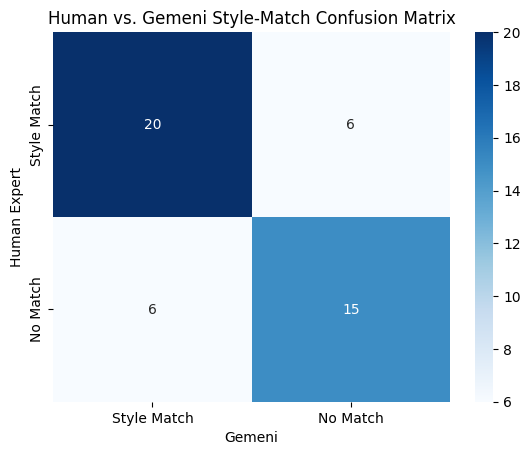

In [128]:
#----------------------------------------
# The confusion matrix when the label is '[Expert]Agree/Disagree' and we use prompt version 3

# Potential improvement: 
# 1. Make Gemeni more strict (give more mismatch)
# 2. In prompt, mention the setting is bathroom
#----------------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

path = '/home/jupyter/Style_annotation_prod/Annotation_results/dining_room_1_v5_results.csv'
confusion_matrix('simple_compatible','Gemeni_compatible',pd.read_csv(path))

Confusion matrix (counts):
             Style Match  No Match
Style Match           84         9
No Match              30         9


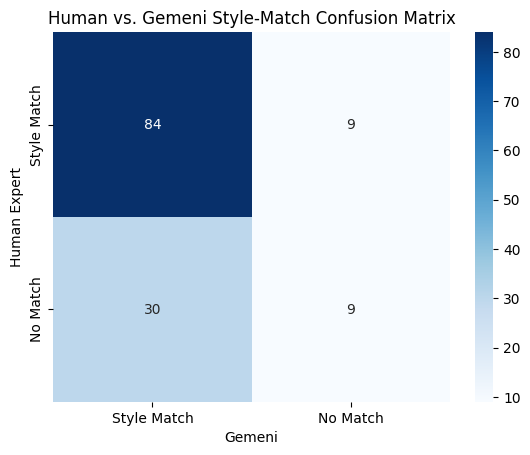

In [75]:
#----------------------------------------
# The confusion matrix when the label is '[Expert] stylistically relevant AND complementary? '
# Based on the confusion matrix, there are many cases where Gemeni thinks styles match while human doesn't.
# If we want to switch label to '[Expert] stylistically relevant AND complementary? ', we can let Gemeni be more strict
#----------------------------------------

path = '/home/jupyter/Style_annotation/Annotation_results/llm_style_annotations_poc_newlabel_2.5.csv'
result_file = pd.read_csv(path)
confusion_matrix('simple_compatible','Gemeni_compatible',result_file)

Confusion matrix (counts):
             Style Match  No Match
Style Match           89        26
No Match               6        12


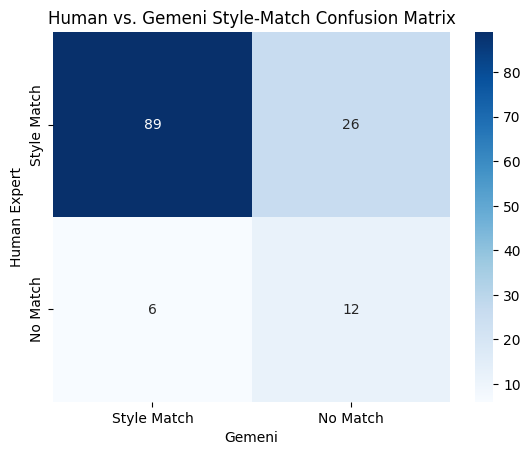

In [61]:
#----------------------------------------
# The confusion matrix when the label is '[Expert]Agree/Disagree'
#----------------------------------------

cm_manual = pd.DataFrame(
    [
        [89, 26],   # Human=Agree (Style Match)
        [6, 12],   # Human=Disagree (No Match)
    ],
    index=["Style Match", "No Match"],    # human side
    columns=["Style Match", "No Match"]   # ChatGPT side
)

# 2) Print it
print("Confusion matrix (counts):")
print(cm_manual)

# 3) (Optional) visualize with seaborn
sns.heatmap(cm_manual, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Gemeni")
plt.ylabel("Human Expert")
plt.title("Human vs. Gemeni Style‐Match Confusion Matrix")
plt.show()

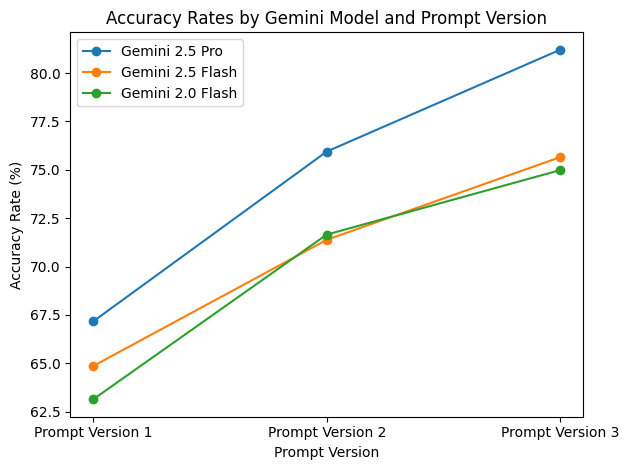

In [64]:
#----------------------------------------
# The accuracy rate over differnt foundation models and prompt versions
#----------------------------------------

import matplotlib.pyplot as plt

# Data
versions = ["Prompt Version 1", "Prompt Version 2", "Prompt Version 3"]
gemini25_pro = [67.17, 75.94, 81.20]
gemini25_flash = [64.86, 71.38, 75.65]
gemini20_flash = [63.14, 71.65, 74.98]

# Plot
plt.figure()
plt.plot(versions, gemini25_pro, marker='o', label='Gemini 2.5 Pro')
plt.plot(versions, gemini25_flash, marker='o', label='Gemini 2.5 Flash')
plt.plot(versions, gemini20_flash, marker='o', label='Gemini 2.0 Flash')

# Labels and title
plt.xlabel('Prompt Version')
plt.ylabel('Accuracy Rate (%)')
plt.title('Accuracy Rates by Gemini Model and Prompt Version')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

file_path = "/home/jupyter/wayfair_templates/Data/LLM Style Annotations.xlsx"
df = pd.read_excel(file_path, engine = 'openpyxl')
df.head()

,product_1,Title 1,product_1_img,Image 1,product_2,Title 2,product_2_img,Image 2,Simple Rule,ChatGPT,...,ChatGPT Explanation on if they are stylistically compatible,[Expert] Agree/Disagree,[Expert] Justification,[Expert] stylistically relevant AND complementary?,"[Expert] Rating 1-10 for stylistic relevancy (10 being the most relevant, optional)",[Expert] Name this style (optional),Yes and Agree,No and Agree,Yes and Disagree,No and Disagree
0,BYIL5679,Schmitz 6 Piece Conservatory Living Room Set,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,KTHM5444,"Amilio 28"" W Polyester Armchair with Solid Woo...",http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,no,yes,...,Both products blend tropical and contemporary ...,Disagree,The Schmitz 6 piece set is made of wicker/ratt...,No,1.0,NaN,0,0,1,0
1,XJT10458,"Amala 90"" Round Arm Sofa, Boucle",http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,WKAK1004,"Jessel Mid Century Modern Coffee Table, Nestin...",http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,yes,yes,...,Both items exhibit key characteristics of Mode...,Agree,Styles work well together. Metal base of the ...,Yes,9.0,NaN,1,0,0,0
2,BLOV2276,Jahmauri 2 - Piece Living Room Table Set,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,AHSV8489,Kayzen 3 - Piece Living Room Set,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,no,yes,...,Both the Jahmauri 2-Piece Living Room Table Se...,Agree,"Even though the wood tones don't match, the st...",Yes,6.0,NaN,1,0,0,0
3,RDHN2500,Halima Carved Wood Frame 5-piece Living Room Set,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,KTHM3151,Kass Armchair With Nailhead Trims,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,no,yes,...,"Both products, the Halima Carved Wood Frame 5-...",Agree,Rolled arms and curved back of both the sofa a...,Yes,7.0,NaN,1,0,0,0
4,GOBK1029,Leshawna 6 - Piece Living Room Set,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,EBOX9097,Scottsmoor Modern Halo High Gloss Statement Lu...,http://assets.wfcdn.com/im/70d43eef/resize-h50...,NaN,yes,yes,...,Both the Leshawna 6 - Piece Living Room Set an...,Agree,Styles work well together. The metallic table...,Yes,10.0,NaN,1,0,0,0


In [1]:
import sys
print(sys.executable)


/home/jupyter/Style_annotation/.venv/bin/python
